In [16]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [17]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [18]:
dataset= tf.keras.preprocessing.image_dataset_from_directory("/content/drive/MyDrive/Dataset",shuffle=True, image_size=(IMAGE_SIZE,IMAGE_SIZE), batch_size= BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [19]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

(32, 256, 256, 3)
[1 0 0 0 0 1 0 1 0 1 0 1 1 0 0 2 0 0 0 1 0 0 0 1 2 0 1 0 0 1 1 1]


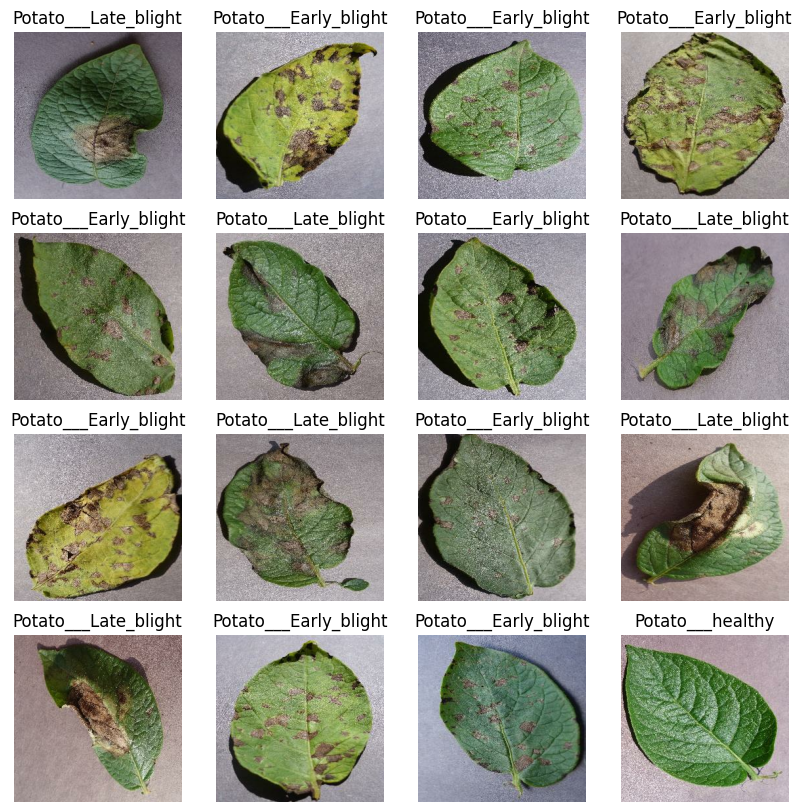

In [20]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in dataset.take(1):
  print(image_batch.shape)
  print(labels_batch.numpy())
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[labels_batch[i]])
    plt.axis("off")

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  assert(train_split+test_split+val_split)==1
  ds_size = len(ds)
  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=6)
  train_size=int(train_split*ds_size)
  val_size=int(val_split*ds_size)
  train_ds=ds.take(train_size)
  val_ds=ds.skip(train_size).take(val_size)
  test_ds=ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [22]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

In [26]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[0].numpy()/255)

[[[0.7372549  0.73333335 0.75686276]
  [0.7411765  0.7372549  0.7607843 ]
  [0.7529412  0.7490196  0.77254903]
  ...
  [0.654902   0.64705884 0.69803923]
  [0.6862745  0.6784314  0.7294118 ]
  [0.7294118  0.72156864 0.77254903]]

 [[0.74509805 0.7411765  0.7647059 ]
  [0.7490196  0.74509805 0.76862746]
  [0.75686276 0.7529412  0.7764706 ]
  ...
  [0.68235296 0.6745098  0.7254902 ]
  [0.69411767 0.6862745  0.7372549 ]
  [0.7176471  0.70980394 0.7607843 ]]

 [[0.7294118  0.7254902  0.7490196 ]
  [0.73333335 0.7294118  0.7529412 ]
  [0.7372549  0.73333335 0.75686276]
  ...
  [0.7058824  0.69803923 0.7490196 ]
  [0.69803923 0.6901961  0.7411765 ]
  [0.69803923 0.6901961  0.7411765 ]]

 ...

 [[0.57254905 0.56078434 0.5882353 ]
  [0.6039216  0.5921569  0.61960787]
  [0.62352943 0.6117647  0.6392157 ]
  ...
  [0.5176471  0.5058824  0.5411765 ]
  [0.5882353  0.5764706  0.6117647 ]
  [0.5372549  0.5254902  0.56078434]]

 [[0.5882353  0.5764706  0.6039216 ]
  [0.6        0.5882353  0.6156863 ]


In [28]:
resizing_and_rescaling=tf.keras.Sequential([layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)])

In [29]:
data_augmentation=tf.keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),layers.experimental.preprocessing.RandomRotation(0.2)])

In [30]:
input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3
model=models.Sequential([
    resizing_and_rescaling,
    data_augmentation,
    layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])
model.build(input_shape=input_shape)

In [31]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_3 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [32]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [33]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS
)

Epoch 1/50
54/54 [==============================] - 329s 143ms/step - loss: 0.9025 - accuracy: 0.4877 - val_loss: 0.9253 - val_accuracy: 0.6875
Epoch 2/50
54/54 [==============================] - 3s 61ms/step - loss: 0.7787 - accuracy: 0.6444 - val_loss: 0.6414 - val_accuracy: 0.7292
Epoch 3/50
54/54 [==============================] - 3s 59ms/step - loss: 0.5424 - accuracy: 0.7559 - val_loss: 0.6068 - val_accuracy: 0.6771
Epoch 4/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3850 - accuracy: 0.8380 - val_loss: 0.8320 - val_accuracy: 0.6823
Epoch 5/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2949 - accuracy: 0.8768 - val_loss: 0.3692 - val_accuracy: 0.8490
Epoch 6/50
54/54 [==============================] - 3s 60ms/step - loss: 0.2497 - accuracy: 0.9002 - val_loss: 0.3261 - val_accuracy: 0.8854
Epoch 7/50
54/54 [==============================] - 3s 58ms/step - loss: 0.1819 - accuracy: 0.9313 - val_loss: 0.2797 - val_accuracy: 0.9062
Epoch 8/50

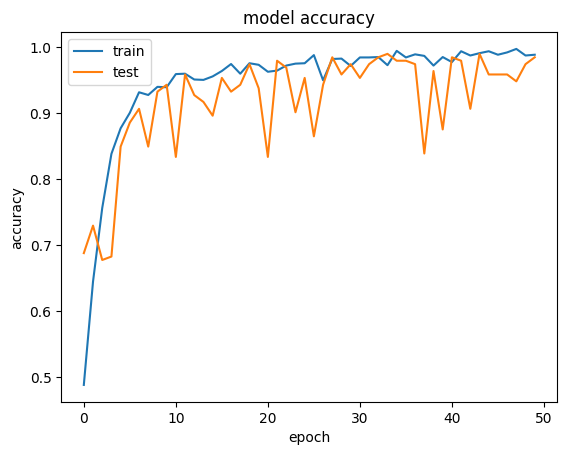

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

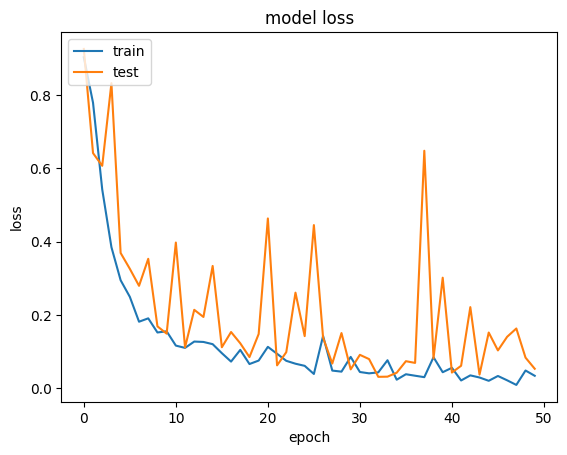

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc='upper left')
plt.show()

In [36]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 4s 28ms/step - loss: 0.0317 - accuracy: 0.9922


In [37]:
def predict (model,img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0)
  predictions=model.predict(img_array)
  predicted_class=class_names[np.argmax(predictions[0])]
  confidence=round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 17ms/step


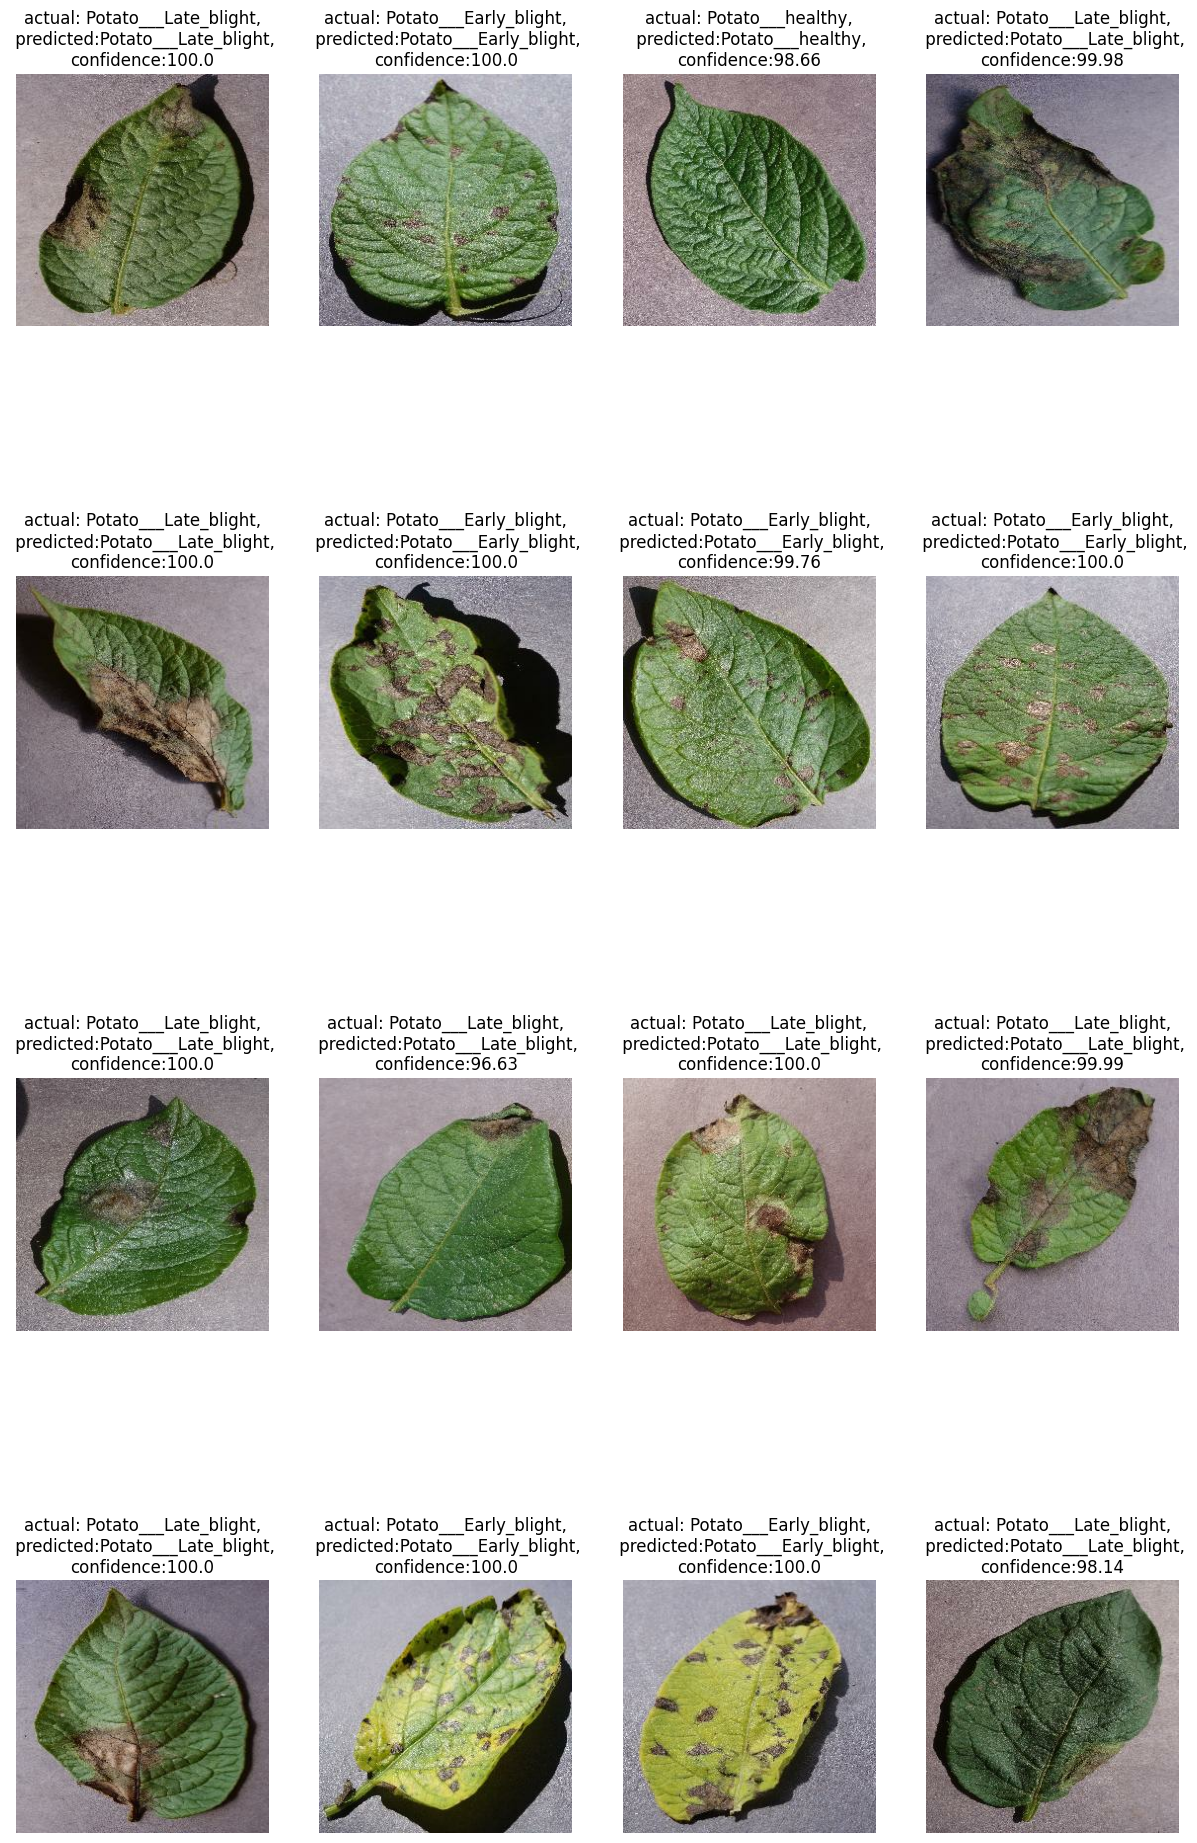

In [38]:
import numpy as np
plt.figure(figsize=(15,25))
for images,labels in test_ds.take(1):
  for i in range(16):
    axisx=plt.subplot(4,4,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    predicted_class, confidence=predict(model,images[i].numpy())
    actual_class=class_names[labels[i]]
    plt.title(f"actual: {actual_class},\n predicted:{predicted_class},\nconfidence:{confidence}")
    plt.axis("off")

In [39]:
model.save("/content/drive/MyDrive/ModelAgriculture.h5")